In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools
import scipy.stats
import iminuit

Welcome to JupyROOT 6.18/00


In [2]:
plt.style.use("cms")

In [3]:
with pd.HDFStore("data/hists.h5") as store:
    print(store.keys())

['/DataAggEvents', '/MCAggEvents', '/MCAggEvents_jer', '/MCAggEvents_jes', '/MCAggEvents_lepscales', '/MCAggEvents_unclust']


In [4]:
df_data = pd.read_hdf("data/hists.h5", "DataAggEvents")
df_mc = pd.read_hdf("data/hists.h5", "MCAggEvents")
df_mc_jes = pd.read_hdf("data/hists.h5", "MCAggEvents_jes")
df_mc_jer = pd.read_hdf("data/hists.h5", "MCAggEvents_jer")
df_mc_unclust = pd.read_hdf("data/hists.h5", "MCAggEvents_unclust")
df_mc_lepscales = pd.read_hdf("data/hists.h5", "MCAggEvents_lepscales")
df_mc.head(10)

count       sum_w  \
table   varname0  selection      parent     binvar0                        
central METnoX_pt DoubleElectron DYJetsToEE 200.0    18359.0  454.123953   
                                            205.0    20113.0  478.451145   
                                            210.0    22838.0  498.160905   
                                            215.0    25355.0  527.516072   
                                            220.0    28335.0  543.682847   
                                            225.0    31719.0  523.077193   
                                            230.0    35266.0  548.306290   
                                            235.0    39310.0  520.081681   
                                            240.0    43133.0  526.956918   
                                            245.0    46272.0  507.985643   

                                                         sum_ww  \
table   varname0  selection      parent     binvar0               
central METnoX_pt DoubleElectron DYJetsToEE 200.0    107.097519   
                                            205.0    110.106198   
                                            210.0    115.083963   
                                            215.0    117.131676   
                                            220.0    118.161899   
                                            225.0    114.165365   
                                            230.0    113.346872   
                                            235.0    105.834841   
                                            240.0    101.076919   
                                            245.0     92.962429   

                                                     sum_w_d1kqcdUp  \
table   varname0  selection      parent     binvar0                   
central METnoX_pt DoubleElectron DYJetsToEE 200.0        434.315916   
                                            205.0        457.405967   
                                            210.0        476.179883   
                                            215.0        504.084742   
                                            220.0        519.366597   
                                            225.0        499.595708   
                                            230.0        523.555763   
                                            235.0        496.527906   
                                            240.0        502.918103   
                                            245.0        484.770462   

                                                     sum_ww_d1kqcdUp  \
table   varname0  selection      parent     binvar0                    
central METnoX_pt DoubleElectron DYJetsToEE 200.0          98.002186   
                                            205.0         100.696528   
                                            210.0         105.200988   
                                            215.0         107.006009   
                                            220.0         107.890501   
                                            225.0         104.200081   
                                            230.0         103.398964   
                                            235.0          96.514390   
                                            240.0          92.139731   
                                            245.0          84.719233   

                                                     sum_w_d1kqcdDown  \
table   varname0  selection      parent     binvar0                     
central METnoX_pt DoubleElectron DYJetsToEE 200.0          476.781717   
                                            205.0          502.548156   
                                            210.0          523.339224   
                                            215.0          554.377076   
                                            220.0          571.582113   
                                            225.0          550.032775   
                                   

# Final binning

Use the final MET bins

In [5]:
met_bins = np.array([200., 220., 250., 280., 310., 340., 370., 400., 430., 470., 510., 550., 590., 640., 690., 740., 790., 840., 900., 960., 1020., 1090., 1160., 1250., 1400.])

In [6]:
_df_data = dftools.transform.rebin(df_data, met_bins)

processes = {
    #"ZJetsToNuNu": ["ZJetsToNuNu"],
    "DYJetsToLL": ["DYJetsToEE", "DYJetsToMuMu", "DYJetsToTauHTauH", "DYJetsToTauHTauL", "DYJetsToTauLTauL"],
    "WJetsToLNu": [
        "WJetsToEMinusNu", "WJetsToEPlusNu", "WJetsToMuMinusNu", "WJetsToMuPlusNu",
        "WJetsToTauLMinusNu", "WJetsToTauLPlusNu", "WJetsToTauHMinusNu", "WJetsToTauHPlusNu",
    ],
    "MinorBkgs": ["Diboson", "EWKV2Jets", "G1Jet", "SingleTop", "TTJets", "VGamma"],
    #"QCD": ["QCD"],
}

_df_mc = dftools.transform.merge(dftools.transform.rebin(df_mc, met_bins), processes)
_df_mc_jes = dftools.transform.merge(dftools.transform.rebin(df_mc_jes, met_bins), processes)
_df_mc_jer = dftools.transform.merge(dftools.transform.rebin(df_mc_jer, met_bins), processes)
_df_mc_unclust = dftools.transform.merge(dftools.transform.rebin(df_mc_unclust, met_bins), processes)
_df_mc_lepscales = dftools.transform.merge(dftools.transform.rebin(df_mc_lepscales, met_bins), processes)
pass

# Fits

## Setup

### Data

In [9]:
path_fit_inputs = "data/fitinputs_v2.h5"
save = True

In [10]:
# Rebin
df_data_fit = _df_data.loc[("central", "METnoX_pt"),:]

# Rename
df_data_fit = df_data_fit.reorder_levels(["binvar0", "selection", "parent"]).unstack().unstack()
df_data_fit["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
df_data_fit = df_data_fit.set_index(["binvar1"], append=True).stack().stack().reorder_levels(["parent", "selection", "binvar0", "binvar1"]).sort_index()
df_data_fit.index.names = ["trigger", "region", "bin_min", "bin_max"]

# Save
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if "Data" in store.keys():
            store.remove("Data")
        store.put("Data", df_data_fit, format='table', append=True, complib='zlib', complevel=9)
df_data_fit.head(5)

count  sum_w  sum_ww
trigger region         bin_min bin_max                      
MET     DoubleElectron 200.0   220.0     71.0   71.0    71.0
                       220.0   250.0    129.0  129.0   129.0
                       250.0   280.0    168.0  168.0   168.0
                       280.0   310.0    126.0  126.0   126.0
                       310.0   340.0     93.0   93.0    93.0

# MC PDFs

In [11]:
# rebin and merge processes
df_mc_pdf = _df_mc.loc[("central", "METnoX_pt"), (c for c in _df_mc.columns if "sum_w_lhePdf" in c)]
df_mc_pdf = df_mc_pdf.stack()
df_mc_pdf.index.names = ["selection", "parent", "binvar0", "variation"]
df_mc_pdf = df_mc_pdf.reset_index("variation")
df_mc_pdf.loc[:, "variation"] = df_mc_pdf["variation"].str.replace("sum_w_", "").str.replace("sum_ww_", "")
df_mc_pdf = df_mc_pdf.set_index("variation", append=True).unstack()
df_mc_pdf_std = df_mc_pdf.std(axis=1)

sumw = _df_mc.loc[("central", "METnoX_pt"), "sum_w"]
sumww = _df_mc.loc[("central", "METnoX_pt"), "sum_ww"]
df_mc_pdf = pd.DataFrame({
    "sum_w_lhePdfWeightUp": sumw + df_mc_pdf_std,
    "sum_ww_lhePdfWeightUp": sumww * (1 + df_mc_pdf_std/sumw)**2,
    "sum_w_lhePdfWeightDown": sumw - df_mc_pdf_std,
    "sum_ww_lhePdfWeightDown": sumww * (1 - df_mc_pdf_std/sumw)**2,
}, index=sumw.index)
df_mc_pdf.head(5)

sum_w_lhePdfWeightUp  \
selection      parent     binvar0                         
DoubleElectron DYJetsToLL 200.0             1979.505662   
                          220.0             3205.068436   
                          250.0             2670.330143   
                          280.0             1922.556267   
                          310.0             1334.196862   

                                   sum_ww_lhePdfWeightUp  \
selection      parent     binvar0                          
DoubleElectron DYJetsToLL 200.0               459.244278   
                          220.0               659.337448   
                          250.0               383.548911   
                          280.0               142.045384   
                          310.0                56.474695   

                                   sum_w_lhePdfWeightDown  \
selection      parent     binvar0                           
DoubleElectron DYJetsToLL 200.0               1937.629538   
                          220.0               3138.910990   
                          250.0               2616.618160   
                          280.0               1885.847235   
                          310.0               1309.543097   

                                   sum_ww_lhePdfWeightDown  
selection      parent     binvar0                           
DoubleElectron DYJetsToLL 200.0                 440.019325  
                          220.0                 632.398935  
                          250.0                 368.274407  
                          280.0                 136.672779  
                          310.0                  54.406859

# MC QCD Scales

In [12]:
df_mc_scale = _df_mc.loc[("central", "METnoX_pt"), (c for c in _df_mc.columns if "sum_w_lheScale" in c)]
df_mc_scale = df_mc_scale.stack()
df_mc_scale.index.names = ["selection", "parent", "binvar0", "variation"]
df_mc_scale = df_mc_scale.reset_index("variation")
df_mc_scale.loc[:, "variation"] = df_mc_scale["variation"].str.replace("sum_w_", "").str.replace("sum_ww_", "")
df_mc_scale = df_mc_scale.set_index("variation", append=True).unstack()
df_mc_scale_min = df_mc_scale.min(axis=1)
df_mc_scale_max = df_mc_scale.max(axis=1)

sumw = _df_mc.loc[("central", "METnoX_pt"), "sum_w"]
sumww = _df_mc.loc[("central", "METnoX_pt"), "sum_ww"]
df_mc_scale = pd.DataFrame({
    "sum_w_lheScaleWeightUp": df_mc_scale_max,
    "sum_ww_lheScaleWeightUp": sumww * (df_mc_scale_max/sumw)**2,
    "sum_w_lheScaleWeightDown": df_mc_scale_min,
    "sum_ww_lheScaleWeightDown": sumww * (df_mc_scale_min/sumw)**2,
}, index=sumw.index)
df_mc_scale.head(5)

sum_w_lheScaleWeightUp  \
selection      parent     binvar0                           
DoubleElectron DYJetsToLL 200.0               1958.567600   
                          220.0               3171.989713   
                          250.0               2643.474152   
                          280.0               1904.201751   
                          310.0               1321.869979   

                                   sum_ww_lheScaleWeightUp  \
selection      parent     binvar0                            
DoubleElectron DYJetsToLL 200.0                 449.580421   
                          220.0                 645.797960   
                          250.0                 375.872864   
                          280.0                 139.346135   
                          310.0                  55.435956   

                                   sum_w_lheScaleWeightDown  \
selection      parent     binvar0                             
DoubleElectron DYJetsToLL 200.0                 1958.567600   
                          220.0                 3171.989713   
                          250.0                 2643.474152   
                          280.0                 1904.201751   
                          310.0                 1321.869979   

                                   sum_ww_lheScaleWeightDown  
selection      parent     binvar0                             
DoubleElectron DYJetsToLL 200.0                   449.580421  
                          220.0                   645.797960  
                          250.0                   375.872864  
                          280.0                   139.346135  
                          310.0                    55.435956

# MC alphas

In [13]:
if "sum_w_alphasDown" in _df_mc.columns:
    _df_mc = _df_mc.drop(["sum_w_alphasDown", "sum_ww_alphasDown"], axis=1)
df_mc_alphas = _df_mc.loc[("central", "METnoX_pt"), ("sum_w", "sum_ww", "sum_w_alphasUp", "sum_ww_alphasUp")]
df_mc_alphas["sum_w_alphasDown"] = df_mc_alphas.eval("sum_w**2/sum_w_alphasUp")
df_mc_alphas["sum_ww_alphasDown"] = df_mc_alphas.eval("sum_ww*(sum_w/sum_w_alphasUp)**2")
df_mc_alphas = df_mc_alphas.drop(["sum_w", "sum_ww", "sum_w_alphasUp", "sum_ww_alphasUp"], axis=1)
df_mc_alphas.head(5)

sum_w_alphasDown  sum_ww_alphasDown
selection      parent     binvar0                                     
DoubleElectron DYJetsToLL 200.0         1939.821333         441.015364
                          220.0         3142.215932         633.731334
                          250.0         2618.370677         368.767887
                          280.0         1884.947630         136.542416
                          310.0         1307.879394          54.268705

# MC Lepton scales

In [14]:
df_mc_leps = _df_mc_lepscales.loc[:,("sum_w", "sum_ww")].reorder_levels(["varname0", "selection", "parent", "binvar0", "table"]).unstack()
df_mc_leps.columns = ["_".join(c) for c in df_mc_leps.columns]
df_mc_leps = df_mc_leps.loc[("METnoX_pt"),:].sort_index()
df_mc_leps.head(5)

sum_w_eleEnergyScaleDown  \
selection      parent     binvar0                             
DoubleElectron DYJetsToLL 200.0                 1736.227689   
                          220.0                 2779.836029   
                          250.0                 2254.510473   
                          280.0                 1583.546022   
                          310.0                 1092.178653   

                                   sum_w_eleEnergyScaleUp  \
selection      parent     binvar0                           
DoubleElectron DYJetsToLL 200.0               2119.537412   
                          220.0               3439.708609   
                          250.0               2827.053513   
                          280.0               1988.528165   
                          310.0               1382.242776   

                                   sum_w_muonPtScaleDown  sum_w_muonPtScaleUp  \
selection      parent     binvar0                                               
DoubleElectron DYJetsToLL 200.0              1766.536936          2139.074654   
                          220.0              2837.488698          3455.702529   
                          250.0              2299.859303          2820.874041   
                          280.0              1602.722066          1975.129296   
                          310.0              1105.831610          1369.741352   

                                   sum_w_photonEnergyScaleDown  \
selection      parent     binvar0                                
DoubleElectron DYJetsToLL 200.0                    1699.249009   
                          220.0                    2724.846092   
                          250.0                    2266.253257   
                          280.0                    1582.138397   
                          310.0                    1091.683876   

                                   sum_w_photonEnergyScaleUp  \
selection      parent     binvar0                              
DoubleElectron DYJetsToLL 200.0                  2070.592985   
                          220.0                  3288.654540   
                          250.0                  2733.619953   
                          280.0                  1972.106421   
                          310.0                  1421.968375   

                                   sum_w_tauPtScaleDown  sum_w_tauPtScaleUp  \
selection      parent     binvar0                                             
DoubleElectron DYJetsToLL 200.0             1725.228534         2197.536041   
                          220.0             2822.028563         3452.303208   
                          250.0             2349.479129         2772.016675   
                          280.0             1643.353523         1925.820220   
                          310.0             1142.737141         1325.599171   

                                   sum_ww_eleEnergyScaleDown  \
selection      parent     binvar0                              
DoubleElectron DYJetsToLL 200.0                   360.494882   
                          220.0                   514.530783   
                          250.0                   294.199243   
                          280.0                   106.234247   
                          310.0                    41.468972   

                                   sum_ww_eleEnergyScaleUp  \
selection      parent     binvar0                            
DoubleElectron DYJetsToLL 200.0                 536.671113   
                          220.0                 783.130156   
                          250.0                 458.508481   
                          280.0                 169.616270   
                          310.0                  66.588216   

                                   sum_ww_muonPtScaleDown  \
selection      parent     binvar0                           
DoubleElectron DYJetsToLL 200.0                367.501532   
                          220.0                527.669198   
   

# MC JES Scales

In [15]:
df_mc_jesvari = _df_mc_jes.loc[:,("sum_w", "sum_ww")].reorder_levels(["varname0", "selection", "parent", "binvar0", "table"]).unstack().loc[:,"sum_w"]

import scipy.special
x = np.sqrt(2)*scipy.special.erfinv(2*np.arange(0.1, 0.91, 0.1)-1)
    
def interpolate_errors(x, y, deg=3):
    results = np.polyval(
        np.polyfit(x, y, deg=deg),
        [-1., 1.],
    )
    return pd.Series({"up":results[1], "down":results[0]})

df_mc_jesvari = df_mc_jesvari.apply(lambda r: interpolate_errors(x, r), axis=1).loc[("METnoX_pt",),:]
df_mc_jesvari.columns = ["sum_w_jesTotalUp", "sum_w_jesTotalDown"]

sumw = _df_mc.loc[("central", "METnoX_pt"), "sum_w"]
sumww = _df_mc.loc[("central", "METnoX_pt"), "sum_ww"]

df_mc_jesvari["sum_ww_jesTotalUp"] = sumww*(df_mc_jesvari["sum_w_jesTotalUp"]/sumw)**2
df_mc_jesvari["sum_ww_jesTotalDown"] = sumww*(df_mc_jesvari["sum_w_jesTotalDown"]/sumw)**2
df_mc_jesvari = df_mc_jesvari[["sum_w_jesTotalUp", "sum_ww_jesTotalUp", "sum_w_jesTotalDown", "sum_ww_jesTotalDown"]].sort_index()
print(df_mc_jesvari.shape)
df_mc_jesvari.head(5)

(1850, 4)


sum_w_jesTotalUp  sum_ww_jesTotalUp  \
selection      parent     binvar0                                        
DoubleElectron DYJetsToLL 200.0         2236.785192         586.379550   
                          220.0         3558.891078         812.947540   
                          250.0         3015.761487         489.198164   
                          280.0         2206.291941         187.066045   
                          310.0         1553.921248          76.607639   

                                   sum_w_jesTotalDown  sum_ww_jesTotalDown  
selection      parent     binvar0                                           
DoubleElectron DYJetsToLL 200.0           1702.975052           339.896607  
                          220.0           2898.930173           539.397138  
                          250.0           2507.886440           338.303563  
                          280.0           1877.380317           135.448290  
                          310.0           1321.429401            55.399009

# MC JER scales

In [16]:
df_mc_jervari = _df_mc_jer.loc[:,("sum_w", "sum_ww")].reorder_levels(["varname0", "selection", "parent", "binvar0", "table"]).unstack().loc[:,"sum_w"]

import scipy.special
x = np.sqrt(2)*scipy.special.erfinv(2*np.arange(0.1, 0.91, 0.1)-1)
    
def interpolate_errors(x, y, deg=3):
    results = np.polyval(
        np.polyfit(x, y, deg=deg),
        [-1., 1.],
    )
    return pd.Series({"up":results[1], "down":results[0]})

df_mc_jervari = df_mc_jervari.apply(lambda r: interpolate_errors(x, r), axis=1).loc[("METnoX_pt",),:]
df_mc_jervari.columns = ["sum_w_jerSFUp", "sum_w_jerSFDown"]

sumw = _df_mc.loc[("central", "METnoX_pt"), "sum_w"]
sumww = _df_mc.loc[("central", "METnoX_pt"), "sum_ww"]

df_mc_jervari["sum_ww_jerSFUp"] = sumww*(df_mc_jervari["sum_w_jerSFUp"]/sumw)**2
df_mc_jervari["sum_ww_jerSFDown"] = sumww*(df_mc_jervari["sum_w_jerSFDown"]/sumw)**2
df_mc_jervari = df_mc_jervari[["sum_w_jerSFUp", "sum_ww_jerSFUp", "sum_w_jerSFDown", "sum_ww_jerSFDown"]].sort_index()
print(df_mc_jervari.shape)
df_mc_jervari.head(5)

(1850, 4)


sum_w_jerSFUp  sum_ww_jerSFUp  \
selection      parent     binvar0                                  
DoubleElectron DYJetsToLL 200.0      2124.852289      529.160902   
                          220.0      3426.055965      753.393787   
                          250.0      2823.294196      428.748988   
                          280.0      1992.320673      152.541316   
                          310.0      1379.049686       60.335636   

                                   sum_w_jerSFDown  sum_ww_jerSFDown  
selection      parent     binvar0                                     
DoubleElectron DYJetsToLL 200.0        1775.220634        369.347303  
                          220.0        2849.459173        521.144317  
                          250.0        2327.191599        291.309816  
                          280.0        1619.733492        100.822191  
                          310.0        1122.458661         39.971899

# MC Unclust

In [17]:
df_mc_unclustvari = _df_mc_unclust.loc[:,("sum_w", "sum_ww")].reorder_levels(["varname0", "selection", "parent", "binvar0", "table"]).unstack().loc[:,"sum_w"]

import scipy.special
x = np.sqrt(2)*scipy.special.erfinv(2*np.arange(0.1, 0.91, 0.1)-1)
    
def interpolate_errors(x, y, deg=3):
    results = np.polyval(
        np.polyfit(x, y, deg=deg),
        [-1., 1.],
    )
    return pd.Series({"up":results[1], "down":results[0]})

df_mc_unclustvari = df_mc_unclustvari.apply(lambda r: interpolate_errors(x, r), axis=1).loc[("METnoX_pt",),:]
df_mc_unclustvari.columns = ["sum_w_unclustUp", "sum_w_unclustDown"]

sumw = _df_mc.loc[("central", "METnoX_pt"), "sum_w"]
sumww = _df_mc.loc[("central", "METnoX_pt"), "sum_ww"]

df_mc_unclustvari["sum_ww_unclustUp"] = sumww*(df_mc_unclustvari["sum_w_unclustUp"]/sumw)**2
df_mc_unclustvari["sum_ww_unclustDown"] = sumww*(df_mc_unclustvari["sum_w_unclustDown"]/sumw)**2
df_mc_unclustvari = df_mc_unclustvari[["sum_w_unclustUp", "sum_ww_unclustUp", "sum_w_unclustDown", "sum_ww_unclustDown"]].sort_index()
print(df_mc_unclustvari.shape)
df_mc_unclustvari.head(5)

(1850, 4)


sum_w_unclustUp  sum_ww_unclustUp  \
selection      parent     binvar0                                      
DoubleElectron DYJetsToLL 200.0        2111.979139        522.768614   
                          220.0        3401.940448        742.825053   
                          250.0        2843.278461        434.840140   
                          280.0        1998.565710        153.499113   
                          310.0        1389.193926         61.226554   

                                   sum_w_unclustDown  sum_ww_unclustDown  
selection      parent     binvar0                                         
DoubleElectron DYJetsToLL 200.0          1795.996958          378.043218  
                          220.0          2862.670066          525.987862  
                          250.0          2300.621676          284.695926  
                          280.0          1614.867387          100.217308  
                          310.0          1116.138490           39.523030

# MC Lumi variations

In [18]:
df_mc_lumi = pd.concat([
    _df_mc.loc[("central", "METnoX_pt"),("sum_w", "sum_ww")]*1.025,
    _df_mc.loc[("central", "METnoX_pt"),("sum_w", "sum_ww")]/1.025,
], axis=1)
df_mc_lumi.columns = ["sum_w_lumiUp", "sum_ww_lumiUp", "sum_w_lumiDown", "sum_ww_lumiDown"]
df_mc_lumi.head(5)

sum_w_lumiUp  sum_ww_lumiUp  \
selection      parent     binvar0                                
DoubleElectron DYJetsToLL 200.0     2007.531790     460.819931   
                          220.0     3251.289456     661.942909   
                          250.0     2709.561005     385.269686   
                          280.0     1951.806795     142.829788   
                          310.0     1354.916729      56.821855   

                                   sum_w_lumiDown  sum_ww_lumiDown  
selection      parent     binvar0                                   
DoubleElectron DYJetsToLL 200.0       1910.797659       438.615044  
                          220.0       3094.624110       630.046790  
                          250.0       2578.999172       366.705233  
                          280.0       1857.757806       135.947449  
                          310.0       1289.629248        54.083860

# MC collect everything

In [19]:
# Convert variations from columns to index
df_mc_vari = _df_mc.loc[
    ("central", "METnoX_pt"),
    [c for c in _df_mc.columns if ("sum_w_" in c or "sum_ww_" in c) and "lhe" not in c]
].copy()

# Add other variations
df_mc_vari = pd.concat([df_mc_lumi, df_mc_vari, df_mc_pdf, df_mc_scale, df_mc_alphas, df_mc_leps, df_mc_jesvari, df_mc_jervari, df_mc_unclustvari], axis=1)

df_mc_vari = df_mc_vari.stack()
df_mc_vari.index.names = ["selection", "parent", "binvar0", "variation"]
df_mc_vari = df_mc_vari.reset_index("variation")
df_mc_vari["quantity"] = "sum_w"
df_mc_vari.loc[df_mc_vari["variation"].str.startswith("sum_ww"), "quantity"] = "sum_ww"
df_mc_vari.loc[:,"variation"] = df_mc_vari["variation"].str.replace("sum_w_", "").str.replace("sum_ww_", "")
df_mc_vari = df_mc_vari.set_index(["variation", "quantity"], append=True).unstack()
df_mc_vari.columns = [c[1] for c in df_mc_vari.columns]
df_mc_vari = df_mc_vari.reorder_levels(["selection", "parent", "variation", "binvar0"]).sort_index()

# Add nominal
df_mc_nom = _df_mc.loc[("central", "METnoX_pt"), ("sum_w", "sum_ww")].copy()
df_mc_nom["variation"] = ""
df_mc_nom = df_mc_nom.set_index("variation", append=True).reorder_levels(["selection", "parent", "variation", "binvar0"]).sort_index()
df_mc_fit = pd.concat([df_mc_nom, df_mc_vari], axis=0)

# Rename
df_mc_fit = df_mc_fit.reorder_levels(["binvar0", "selection", "parent", "variation"]).unstack().unstack().unstack()
df_mc_fit["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
df_mc_fit = df_mc_fit.set_index(["binvar1"], append=True).stack().stack().stack().reorder_levels(["selection", "parent", "variation", "binvar0", "binvar1"]).sort_index()
df_mc_fit.index.names = ["region", "process", "variation", "bin_min", "bin_max"]

# Save
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if "MC" in store.keys():
            store.remove("MC")
        store.put("MC", df_mc_fit, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit.head(5)

sum_w      sum_ww
region         process    variation bin_min bin_max                         
DoubleElectron DYJetsToLL           200.0   220.0    1958.567600  449.580421
                                    220.0   250.0    3171.989713  645.797960
                                    250.0   280.0    2643.474152  375.872864
                                    280.0   310.0    1904.201751  139.346135
                                    310.0   340.0    1321.869979   55.435956

# MC Smooth

In [20]:
nominal_mask = (df_mc_fit.index.get_level_values("variation")=="")
df_mc_fit_vari = df_mc_fit.loc[~nominal_mask].reset_index(["variation", "bin_min", "bin_max"])
df_mc_fit_vari["updown"] = "Up"
df_mc_fit_vari.loc[df_mc_fit_vari["variation"].str.endswith("Down"), "updown"] = "Down"
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["variation"].str.endswith("Down"),
    df_mc_fit_vari["variation"].str.slice(0, -4),
    df_mc_fit_vari["variation"].str.slice(0, -2),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "bin_min", "bin_max", "updown"], append=True).unstack()
df_mc_fit_vari.columns = ["_".join(c) for c in df_mc_fit_vari.columns]

# add nominal values
df_mc_fit_vari = pd.merge(
    df_mc_fit_vari,
    df_mc_fit.loc[nominal_mask,:].reset_index("variation", drop=True),
    right_index=True, left_index=True,
)
df_mc_fit_vari["bin_cent"] = (df_mc_fit_vari.index.get_level_values("bin_min")+df_mc_fit_vari.index.get_level_values("bin_max"))/2.
df_mc_fit_vari["up_norm"] = df_mc_fit_vari.eval("sum_w_Up/sum_w")
df_mc_fit_vari["do_norm"] = df_mc_fit_vari.eval("sum_w_Down/sum_w")
df_mc_fit_vari["up_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Up - sum_ww_Down))/sum_w")
df_mc_fit_vari["do_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Down - sum_ww))/sum_w")

mask = (df_mc_fit_vari["sum_w"]==0.)
df_mc_fit_vari.loc[mask, "up_norm"] = 1.
df_mc_fit_vari.loc[mask, "do_norm"] = 1.
df_mc_fit_vari.loc[mask, "up_err"] = 100.
df_mc_fit_vari.loc[mask, "do_err"] = 100.

mask = (df_mc_fit_vari["do_err"]==0.)
df_mc_fit_vari.loc[mask, "do_err"] = df_mc_fit_vari.loc[mask, "up_err"].copy()

df_mc_fit_vari.loc[:, "up_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["up_err"]))
df_mc_fit_vari.loc[:, "do_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["do_err"]))

#def unispline_to_gausfilter(x, y):
#    s = UnivariateSpline(x, y, w=err)
def smoother(df):
    return pd.DataFrame({
        "upsmooth": dftools.smooth.unispline_to_gausfilter(
            df["bin_cent"].values, df["up_norm"].values, w=1./df["up_err"],
            filter_kw={"sigma": 2},
            spline_kw={"k": 2}, #, "s": df.shape[0]*4},
        ),
        "dosmooth": dftools.smooth.unispline_to_gausfilter(
            df["bin_cent"].values, df["do_norm"].values, w=1./df["do_err"],
            filter_kw={"sigma": 2},
            spline_kw={"k": 2}, #"s": df.shape[0]*4},
        ),
    }, index=df.index)

df_mc_fit_vari = pd.concat([
    df_mc_fit_vari,
    df_mc_fit_vari.groupby(["region", "process", "variation"]).apply(smoother)
], axis=1)
df_mc_fit_vari["sum_w_upsmooth"] = df_mc_fit_vari.eval("sum_w*upsmooth")
df_mc_fit_vari["sum_w_dosmooth"] = df_mc_fit_vari.eval("sum_w*dosmooth")
df_mc_fit_vari_sum = df_mc_fit_vari[["sum_w", "sum_w_Up", "sum_w_Down", "sum_w_upsmooth", "sum_w_dosmooth"]].groupby(["region", "process", "variation"]).sum()

df_mc_fit_vari = df_mc_fit_vari.reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()

sum_w_up = df_mc_fit_vari.eval("sum_w*upsmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Up/sum_w_upsmooth"))
sum_w_do = df_mc_fit_vari.eval("sum_w*dosmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Down/sum_w_dosmooth"))

df_mc_fit_vari = pd.DataFrame({
    "sum_wUp": sum_w_up.values,
    "sum_wwUp": df_mc_fit_vari["sum_ww_Up"].values,
    "sum_wDown": sum_w_do.values,
    "sum_wwDown": df_mc_fit_vari["sum_ww_Down"].values,
}, index=df_mc_fit_vari.index)

df_mc_fit_vari.columns.name = "type"
df_mc_fit_vari = df_mc_fit_vari.stack().reset_index(["variation", "type"])
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["variation"]+"Up",
    df_mc_fit_vari["variation"]+"Down",
)
df_mc_fit_vari.loc[:, "type"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["type"].str.slice(0, -2),
    df_mc_fit_vari["type"].str.slice(0, -4),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "type"], append=True).unstack().reorder_levels([
    "region", "process", "variation", "bin_min", "bin_max"
]).sort_index()
df_mc_fit_vari.columns = [c[1] for c in df_mc_fit_vari.columns]

print(df_mc_fit_vari)

# Add nominal
df_mc_nom = _df_mc.loc[("central", "METnoX_pt"), ("sum_w", "sum_ww")].copy()
df_mc_nom["variation"] = ""
df_mc_nom = df_mc_nom.set_index("variation", append=True).reorder_levels(["selection", "parent", "variation", "binvar0"]).sort_index()
df_mc_fit_smooth = pd.concat([df_mc_nom, df_mc_fit_vari], axis=0, sort=True)

# Rename
df_mc_fit_smooth = df_mc_fit_smooth.reorder_levels(["binvar0", "selection", "parent", "variation"]).unstack().unstack().unstack()
df_mc_fit_smooth["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
df_mc_fit_smooth = df_mc_fit_smooth.set_index(["binvar1"], append=True).stack().stack().stack().reorder_levels(["selection", "parent", "variation", "binvar0", "binvar1"]).sort_index()
df_mc_fit_smooth.index.names = ["region", "process", "variation", "bin_min", "bin_max"]

# Save
name = "MCSmooth"
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if name in store.keys():
            store.remove(name)
        store.put(name, df_mc_fit_smooth, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit_smooth

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


                                                             sum_w      sum_ww
region         process     variation  bin_min bin_max                         
DoubleElectron DYJetsToLL  alphasDown 200.0   220.0    1939.602862  441.015364
                                      220.0   250.0    3141.121429  633.731334
                                      250.0   280.0    2617.520455  368.767887
                                      280.0   310.0    1885.298440  136.542416
                                      310.0   340.0    1308.590841   54.268705
...                                                            ...         ...
SingleTau      ZJetsToNuNu unclustUp  1020.0  1090.0      0.057607    0.000215
                                      1090.0  1160.0      0.032712    0.000268
                                      1160.0  1250.0      0.030849    0.000218
                                      1250.0  1400.0      0.007822    0.000184
                                      1400.0  1550.0

sum_w      sum_ww
region         process     variation bin_min bin_max                         
DoubleElectron DYJetsToLL            200.0   220.0    1958.567600  449.580421
                                     220.0   250.0    3171.989713  645.797960
                                     250.0   280.0    2643.474152  375.872864
                                     280.0   310.0    1904.201751  139.346135
                                     310.0   340.0    1321.869979   55.435956
...                                                           ...         ...
SingleTau      ZJetsToNuNu unclustUp 1020.0  1090.0      0.057607    0.000215
                                     1090.0  1160.0      0.032712    0.000268
                                     1160.0  1250.0      0.030849    0.000218
                                     1250.0  1400.0      0.007822    0.000184
                                     1400.0  1550.0      0.018166    0.000101

[160950 rows x 2 columns]

In [21]:
nominal_mask = (df_mc_fit.index.get_level_values("variation")=="")
df_mc_fit_vari = df_mc_fit.loc[~nominal_mask].reset_index(["variation", "bin_min", "bin_max"])
df_mc_fit_vari["updown"] = "Up"
df_mc_fit_vari.loc[df_mc_fit_vari["variation"].str.endswith("Down"), "updown"] = "Down"
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["variation"].str.endswith("Down"),
    df_mc_fit_vari["variation"].str.slice(0, -4),
    df_mc_fit_vari["variation"].str.slice(0, -2),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "bin_min", "bin_max", "updown"], append=True).unstack()
df_mc_fit_vari.columns = ["_".join(c) for c in df_mc_fit_vari.columns]

# add nominal values
df_mc_fit_vari = pd.merge(
    df_mc_fit_vari,
    df_mc_fit.loc[nominal_mask,:].reset_index("variation", drop=True),
    right_index=True, left_index=True,
)
df_mc_fit_vari["bin_cent"] = (df_mc_fit_vari.index.get_level_values("bin_min")+df_mc_fit_vari.index.get_level_values("bin_max"))/2.
df_mc_fit_vari["up_norm"] = df_mc_fit_vari.eval("sum_w_Up/sum_w")
df_mc_fit_vari["do_norm"] = df_mc_fit_vari.eval("sum_w_Down/sum_w")
df_mc_fit_vari["up_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Up - sum_ww_Down))/sum_w")
df_mc_fit_vari["do_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Down - sum_ww))/sum_w")

mask = (df_mc_fit_vari["sum_w"]==0.)
df_mc_fit_vari.loc[mask, "up_norm"] = 1.
df_mc_fit_vari.loc[mask, "do_norm"] = 1.
df_mc_fit_vari.loc[mask, "up_err"] = 100.
df_mc_fit_vari.loc[mask, "do_err"] = 100.

mask = (df_mc_fit_vari["do_err"]==0.)
df_mc_fit_vari.loc[mask, "do_err"] = df_mc_fit_vari.loc[mask, "up_err"].copy()

df_mc_fit_vari.loc[:, "up_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["up_err"]))
df_mc_fit_vari.loc[:, "do_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["do_err"]))

#def unispline_to_gausfilter(x, y):
#    s = UnivariateSpline(x, y, w=err)
def smoother(df):
    return pd.DataFrame({
        "upsmooth": dftools.smooth.unispline_to_gausfilter(
            df["bin_cent"].values, df["up_norm"].values, w=1./df["up_err"]**2,
            filter_kw={"sigma": 2},
            spline_kw={"k": 2}, #, "s": df.shape[0]*4},
        ),
        "dosmooth": dftools.smooth.unispline_to_gausfilter(
            df["bin_cent"].values, df["do_norm"].values, w=1./df["do_err"]**2,
            filter_kw={"sigma": 2},
            spline_kw={"k": 2}, #"s": df.shape[0]*4},
        ),
    }, index=df.index)

df_mc_fit_vari = pd.concat([
    df_mc_fit_vari,
    df_mc_fit_vari.groupby(["region", "process", "variation"]).apply(smoother)
], axis=1)
df_mc_fit_vari["sum_w_upsmooth"] = df_mc_fit_vari.eval("sum_w*upsmooth")
df_mc_fit_vari["sum_w_dosmooth"] = df_mc_fit_vari.eval("sum_w*dosmooth")
df_mc_fit_vari_sum = df_mc_fit_vari[["sum_w", "sum_w_Up", "sum_w_Down", "sum_w_upsmooth", "sum_w_dosmooth"]].groupby(["region", "process", "variation"]).sum()

df_mc_fit_vari = df_mc_fit_vari.reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()

sum_w_up = df_mc_fit_vari.eval("sum_w*upsmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Up/sum_w_upsmooth"))
sum_w_do = df_mc_fit_vari.eval("sum_w*dosmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Down/sum_w_dosmooth"))

df_mc_fit_vari = pd.DataFrame({
    "sum_wUp": sum_w_up.values,
    "sum_wwUp": df_mc_fit_vari["sum_ww_Up"].values,
    "sum_wDown": sum_w_do.values,
    "sum_wwDown": df_mc_fit_vari["sum_ww_Down"].values,
}, index=df_mc_fit_vari.index)

df_mc_fit_vari.columns.name = "type"
df_mc_fit_vari = df_mc_fit_vari.stack().reset_index(["variation", "type"])
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["variation"]+"Up",
    df_mc_fit_vari["variation"]+"Down",
)
df_mc_fit_vari.loc[:, "type"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["type"].str.slice(0, -2),
    df_mc_fit_vari["type"].str.slice(0, -4),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "type"], append=True).unstack().reorder_levels([
    "region", "process", "variation", "bin_min", "bin_max"
]).sort_index()
df_mc_fit_vari.columns = [c[1] for c in df_mc_fit_vari.columns]

print(df_mc_fit_vari)

# Add nominal
df_mc_nom = _df_mc.loc[("central", "METnoX_pt"), ("sum_w", "sum_ww")].copy()
df_mc_nom["variation"] = ""
df_mc_nom = df_mc_nom.set_index("variation", append=True).reorder_levels(["selection", "parent", "variation", "binvar0"]).sort_index()
df_mc_fit_smooth = pd.concat([df_mc_nom, df_mc_fit_vari], axis=0, sort=True)

# Rename
df_mc_fit_smooth = df_mc_fit_smooth.reorder_levels(["binvar0", "selection", "parent", "variation"]).unstack().unstack().unstack()
df_mc_fit_smooth["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
df_mc_fit_smooth = df_mc_fit_smooth.set_index(["binvar1"], append=True).stack().stack().stack().reorder_levels(["selection", "parent", "variation", "binvar0", "binvar1"]).sort_index()
df_mc_fit_smooth.index.names = ["region", "process", "variation", "bin_min", "bin_max"]

# Save
name = "MCSmoothv2"
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if name in store.keys():
            store.remove(name)
        store.put(name, df_mc_fit_smooth, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit_smooth

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


                                                             sum_w      sum_ww
region         process     variation  bin_min bin_max                         
DoubleElectron DYJetsToLL  alphasDown 200.0   220.0    1939.934808  441.015364
                                      220.0   250.0    3141.537989  633.731334
                                      250.0   280.0    2617.647283  368.767887
                                      280.0   310.0    1885.160242  136.542416
                                      310.0   340.0    1308.330345   54.268705
...                                                            ...         ...
SingleTau      ZJetsToNuNu unclustUp  1020.0  1090.0      0.054507    0.000215
                                      1090.0  1160.0      0.030398    0.000268
                                      1160.0  1250.0      0.027854    0.000218
                                      1250.0  1400.0      0.006842    0.000184
                                      1400.0  1550.0

sum_w      sum_ww
region         process     variation bin_min bin_max                         
DoubleElectron DYJetsToLL            200.0   220.0    1958.567600  449.580421
                                     220.0   250.0    3171.989713  645.797960
                                     250.0   280.0    2643.474152  375.872864
                                     280.0   310.0    1904.201751  139.346135
                                     310.0   340.0    1321.869979   55.435956
...                                                           ...         ...
SingleTau      ZJetsToNuNu unclustUp 1020.0  1090.0      0.054507    0.000215
                                     1090.0  1160.0      0.030398    0.000268
                                     1160.0  1250.0      0.027854    0.000218
                                     1250.0  1400.0      0.006842    0.000184
                                     1400.0  1550.0      0.015563    0.000101

[160950 rows x 2 columns]

# MC Smooth - polyfit

In [22]:
nominal_mask = (df_mc_fit.index.get_level_values("variation")=="")
df_mc_fit_vari = df_mc_fit.loc[~nominal_mask].reset_index(["variation", "bin_min", "bin_max"])
df_mc_fit_vari["updown"] = "Up"
df_mc_fit_vari.loc[df_mc_fit_vari["variation"].str.endswith("Down"), "updown"] = "Down"
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["variation"].str.endswith("Down"),
    df_mc_fit_vari["variation"].str.slice(0, -4),
    df_mc_fit_vari["variation"].str.slice(0, -2),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "bin_min", "bin_max", "updown"], append=True).unstack()
df_mc_fit_vari.columns = ["_".join(c) for c in df_mc_fit_vari.columns]

# add nominal values
df_mc_fit_vari = pd.merge(
    df_mc_fit_vari,
    df_mc_fit.loc[nominal_mask,:].reset_index("variation", drop=True),
    right_index=True, left_index=True,
)
df_mc_fit_vari["bin_cent"] = (df_mc_fit_vari.index.get_level_values("bin_min")+df_mc_fit_vari.index.get_level_values("bin_max"))/2.
df_mc_fit_vari["up_norm"] = df_mc_fit_vari.eval("sum_w_Up/sum_w")
df_mc_fit_vari["do_norm"] = df_mc_fit_vari.eval("sum_w_Down/sum_w")
df_mc_fit_vari["up_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Up - sum_ww_Down))/sum_w")
df_mc_fit_vari["do_err"] = df_mc_fit_vari.eval("sqrt(abs(sum_ww_Down - sum_ww))/sum_w")

mask = (df_mc_fit_vari["sum_w"]==0.)
df_mc_fit_vari.loc[mask, "up_norm"] = 1.
df_mc_fit_vari.loc[mask, "do_norm"] = 1.
df_mc_fit_vari.loc[mask, "up_err"] = 100.
df_mc_fit_vari.loc[mask, "do_err"] = 100.

mask = (df_mc_fit_vari["do_err"]==0.)
df_mc_fit_vari.loc[mask, "do_err"] = df_mc_fit_vari.loc[mask, "up_err"].copy()

df_mc_fit_vari.loc[:, "up_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["up_err"]))
df_mc_fit_vari.loc[:, "do_err"] = np.maximum(1e-4, np.minimum(1., df_mc_fit_vari["do_err"]))

def polyfit(x, y, err, deg=4):
    return np.polyval(np.polyfit(x, y, w=1/err, deg=deg), x)

df_mc_fit_vari = pd.concat([
    df_mc_fit_vari,
    df_mc_fit_vari.groupby(["region", "process", "variation"]).apply(smoother)
], axis=1)
df_mc_fit_vari["sum_w_upsmooth"] = df_mc_fit_vari.eval("sum_w*upsmooth")
df_mc_fit_vari["sum_w_dosmooth"] = df_mc_fit_vari.eval("sum_w*dosmooth")
df_mc_fit_vari_sum = df_mc_fit_vari[["sum_w", "sum_w_Up", "sum_w_Down", "sum_w_upsmooth", "sum_w_dosmooth"]].groupby(["region", "process", "variation"]).sum()

df_mc_fit_vari = df_mc_fit_vari.reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()

sum_w_up = df_mc_fit_vari.eval("sum_w*upsmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Up/sum_w_upsmooth"))
sum_w_do = df_mc_fit_vari.eval("sum_w*dosmooth").multiply(df_mc_fit_vari_sum.eval("sum_w_Down/sum_w_dosmooth"))

df_mc_fit_vari = pd.DataFrame({
    "sum_wUp": sum_w_up.values,
    "sum_wwUp": df_mc_fit_vari["sum_ww_Up"].values,
    "sum_wDown": sum_w_do.values,
    "sum_wwDown": df_mc_fit_vari["sum_ww_Down"].values,
}, index=df_mc_fit_vari.index)

df_mc_fit_vari.columns.name = "type"
df_mc_fit_vari = df_mc_fit_vari.stack().reset_index(["variation", "type"])
df_mc_fit_vari.loc[:, "variation"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["variation"]+"Up",
    df_mc_fit_vari["variation"]+"Down",
)
df_mc_fit_vari.loc[:, "type"] = np.where(
    df_mc_fit_vari["type"].str.endswith("Up"),
    df_mc_fit_vari["type"].str.slice(0, -2),
    df_mc_fit_vari["type"].str.slice(0, -4),
)
df_mc_fit_vari = df_mc_fit_vari.set_index(["variation", "type"], append=True).unstack().reorder_levels([
    "region", "process", "variation", "bin_min", "bin_max"
]).sort_index()
df_mc_fit_vari.columns = [c[1] for c in df_mc_fit_vari.columns]

print(df_mc_fit_vari)

# Add nominal
df_mc_nom = _df_mc.loc[("central", "METnoX_pt"), ("sum_w", "sum_ww")].copy()
df_mc_nom["variation"] = ""
df_mc_nom = df_mc_nom.set_index("variation", append=True).reorder_levels(["selection", "parent", "variation", "binvar0"]).sort_index()
df_mc_fit_pol4 = pd.concat([df_mc_nom, df_mc_fit_vari], axis=0, sort=True)

# Rename
df_mc_fit_pol4 = df_mc_fit_pol4.reorder_levels(["binvar0", "selection", "parent", "variation"]).unstack().unstack().unstack()
df_mc_fit_pol4["binvar1"] = list(met_bins[1:])+[2*met_bins[-1]-met_bins[-2]]
df_mc_fit_pol4 = df_mc_fit_pol4.set_index(["binvar1"], append=True).stack().stack().stack().reorder_levels(["selection", "parent", "variation", "binvar0", "binvar1"]).sort_index()
df_mc_fit_pol4.index.names = ["region", "process", "variation", "bin_min", "bin_max"]

# Save
name = "MCPoly4"
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if name in store.keys():
            store.remove(name)
        store.put(name, df_mc_fit_pol4, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit_pol4

                                                             sum_w      sum_ww
region         process     variation  bin_min bin_max                         
DoubleElectron DYJetsToLL  alphasDown 200.0   220.0    1939.934808  441.015364
                                      220.0   250.0    3141.537989  633.731334
                                      250.0   280.0    2617.647283  368.767887
                                      280.0   310.0    1885.160242  136.542416
                                      310.0   340.0    1308.330345   54.268705
...                                                            ...         ...
SingleTau      ZJetsToNuNu unclustUp  1020.0  1090.0      0.054507    0.000215
                                      1090.0  1160.0      0.030398    0.000268
                                      1160.0  1250.0      0.027854    0.000218
                                      1250.0  1400.0      0.006842    0.000184
                                      1400.0  1550.0

sum_w      sum_ww
region         process     variation bin_min bin_max                         
DoubleElectron DYJetsToLL            200.0   220.0    1958.567600  449.580421
                                     220.0   250.0    3171.989713  645.797960
                                     250.0   280.0    2643.474152  375.872864
                                     280.0   310.0    1904.201751  139.346135
                                     310.0   340.0    1321.869979   55.435956
...                                                           ...         ...
SingleTau      ZJetsToNuNu unclustUp 1020.0  1090.0      0.054507    0.000215
                                     1090.0  1160.0      0.030398    0.000268
                                     1160.0  1250.0      0.027854    0.000218
                                     1250.0  1400.0      0.006842    0.000184
                                     1400.0  1550.0      0.015563    0.000101

[160950 rows x 2 columns]

# Flat templates

In [23]:
nominal_mask = (df_mc_fit.index.get_level_values("variation")=="")
df_mc_nom = df_mc_fit.loc[nominal_mask].copy()
df_mc_fit_vari = df_mc_fit.loc[~nominal_mask].copy()

df_mc_fit_vari_sum = df_mc_fit_vari.groupby(["region", "process", "variation"]).sum()
df_mc_nom_sum = df_mc_nom.groupby(["region", "process"]).sum()
df_mc_fit_vari_sum = df_mc_fit_vari_sum.divide(df_mc_nom_sum)
df_mc_fit_vari_sum.columns = ["scale_w", "scale_ww"]

df_mc_nom = df_mc_nom.reset_index("variation", drop=True)

df_mc_fit_vari = pd.merge(
    df_mc_fit_vari_sum["scale_w"],
    df_mc_nom[["sum_w", "sum_ww"]],
    right_index=True, left_index=True,
).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
df_mc_fit_vari.loc[:,"sum_w"] = df_mc_fit_vari.eval("scale_w*sum_w")
df_mc_fit_vari.loc[:,"sum_ww"] = df_mc_fit_vari.eval("(scale_w**2)*sum_ww")
df_mc_fit_vari = df_mc_fit_vari.drop("scale_w", axis=1)

df_mc_nom["variation"] = ""
df_mc_nom = df_mc_nom.set_index("variation", append=True).reorder_levels([
    "region", "process", "variation", "bin_min", "bin_max",
]).sort_index()
df_mc_fit_flat = pd.concat([df_mc_nom, df_mc_fit_vari], axis=0, sort=True)

# Save
name = "MCFlat"
if save:
    with pd.HDFStore(path_fit_inputs) as store:
        if name in store.keys():
            store.remove(name)
        store.put(name, df_mc_fit_flat, format='table', append=True, complib='zlib', complevel=9)
df_mc_fit_flat

sum_w      sum_ww
region         process     variation bin_min bin_max                         
DoubleElectron DYJetsToLL            200.0   220.0    1958.567600  449.580421
                                     220.0   250.0    3171.989713  645.797960
                                     250.0   280.0    2643.474152  375.872864
                                     280.0   310.0    1904.201751  139.346135
                                     310.0   340.0    1321.869979   55.435956
...                                                           ...         ...
SingleTau      ZJetsToNuNu unclustUp 1020.0  1090.0      0.054441    0.000286
                                     1090.0  1160.0      0.030531    0.000135
                                     1160.0  1250.0      0.028724    0.000219
                                     1250.0  1400.0      0.007321    0.000092
                                     1400.0  1550.0      0.017099    0.000106

[160950 rows x 2 columns]

In [24]:
def draw(ax, hist1, hist2, hist3, hist4, hist5, hist6, title=""):
    bin_min = hist1.index.get_level_values("bin_min")
    bin_max = hist1.index.get_level_values("bin_max")
    bin_edge = np.array(list(bin_min)+[bin_max[-1]])
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist1["sum_w"], histtype='step',
        color='#1f78b4', label="Jagged",
        ls=':', zorder=-1,
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist2["sum_w"], histtype='step',
        color='#1f78b4', label="Smooth",
        zorder=0,
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist3["sum_w"], histtype='step',
        color='#1f78b4', label="Smooth",
        zorder=1, ls='--',
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist4["sum_w"], histtype='step',
        color='#e31a1c', label="Jagged",
        ls=':', zorder=-1,
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist5["sum_w"], histtype='step',
        color='#e31a1c', label="Jagged",
        zorder=0,
    )
    
    ax.hist(
        bin_min, bins=bin_edge,
        weights=hist6["sum_w"], histtype='step',
        color='#e31a1c', label="Jagged",
        zorder=1, ls='--',
    )
    
    ax.legend([], [], labelspacing=0.1, borderpad=0.1, title=title)
    
    ax.set_xlim(bin_min[0], bin_max[-1])
    max_val = max([0.001, np.abs(hist1["sum_w"]).max(), np.abs(hist2["sum_w"]).max()])
    #ax.set_ylim(-max_val*1.05, max_val*1.05)

In [25]:
df_mc_fit.index.get_level_values("variation").unique()

Index(['', 'alphasDown', 'alphasUp', 'btagSFDown', 'btagSFUp', 'd1kewDown',
       'd1kewUp', 'd1kqcdDown', 'd1kqcdUp', 'd2kewwDown', 'd2kewwUp',
       'd2kewzDown', 'd2kewzUp', 'd2kqcdDown', 'd2kqcdUp', 'd3kewwDown',
       'd3kewwUp', 'd3kewzDown', 'd3kewzUp', 'd3kqcdDown', 'd3kqcdUp',
       'dkmixDown', 'dkmixUp', 'eleEnergyScaleDown', 'eleEnergyScaleUp',
       'eleIdIsoTightDown', 'eleIdIsoTightUp', 'eleIdIsoVetoDown',
       'eleIdIsoVetoUp', 'eleRecoDown', 'eleRecoUp', 'eleTrigDown',
       'eleTrigUp', 'jerSFDown', 'jerSFUp', 'jesTotalDown', 'jesTotalUp',
       'lhePdfWeightDown', 'lhePdfWeightUp', 'lheScaleWeightDown',
       'lheScaleWeightUp', 'lumiDown', 'lumiUp',
       'metTrigMuonMultiplicitySystDown', 'metTrigMuonMultiplicitySystUp',
       'metTrigReferenceTriggerSystDown', 'metTrigReferenceTriggerSystUp',
       'metTrigRegionSystDown', 'metTrigRegionSystUp', 'muonIdLooseStatDown',
       'muonIdLooseStatUp', 'muonIdLooseSystDown', 'muonIdLooseSystUp',
       'muon

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


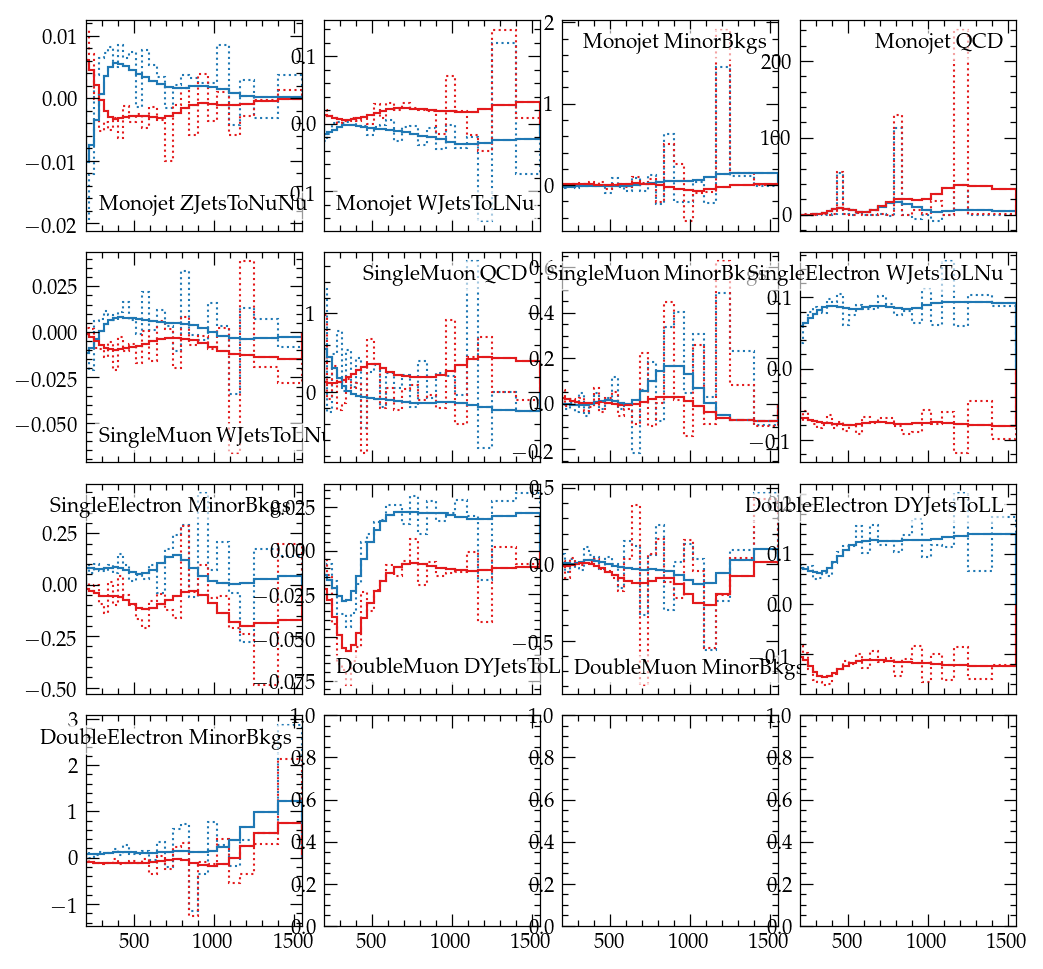

In [26]:
variation = "unclust"

region_processes = [
    ("Monojet", "ZJetsToNuNu"),
    ("Monojet", "WJetsToLNu"),
    ("Monojet", "MinorBkgs"),
    ("Monojet", "QCD"),
    ("SingleMuon", "WJetsToLNu"),
    ("SingleMuon", "QCD"),
    ("SingleMuon", "MinorBkgs"),
    ("SingleElectron", "WJetsToLNu"),
    ("SingleElectron", "MinorBkgs"),
    ("DoubleMuon", "DYJetsToLL"),
    ("DoubleMuon", "MinorBkgs"),
    ("DoubleElectron", "DYJetsToLL"),
    ("DoubleElectron", "MinorBkgs"),
]

nvars = len(region_processes)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

for idx, (region, process) in enumerate(region_processes):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(variation))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(variation))]
    vari_up_pol = df_mc_fit_pol4.loc[(region, process, "{}Up".format(variation))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(variation))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(variation))]
    vari_do_pol = df_mc_fit_pol4.loc[(region, process, "{}Down".format(variation))]
    
    row = idx//4
    col = idx%4
    if len(region_processes)<=4:
        tax = ax[col]
    else:
        tax = ax[row,col]
    draw(
        tax,
        vari_up/nom-1, vari_up_smooth/nom-1, vari_up_pol/nom-1,
        vari_do/nom-1, vari_do_smooth/nom-1, vari_do_pol/nom-1,
        title=" ".join([region, process]),
    )

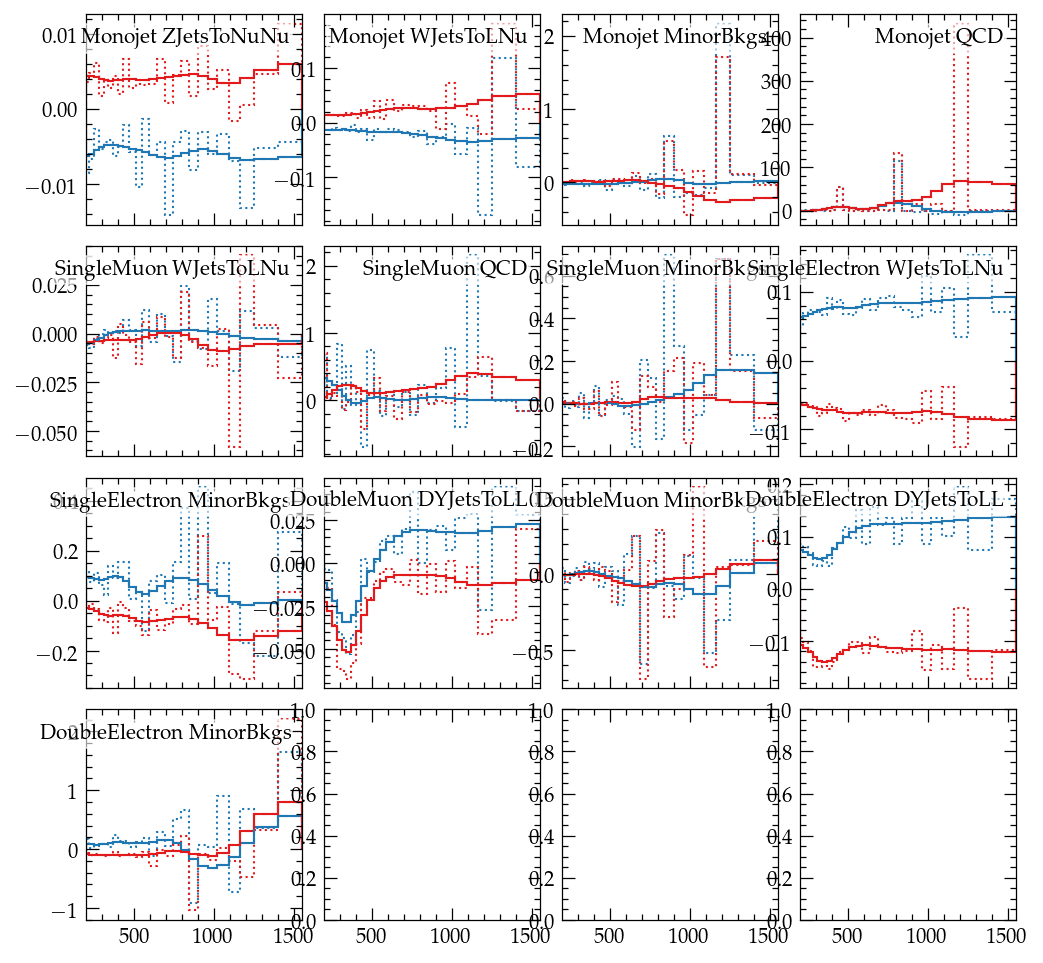

In [27]:
variation = "jerSF"

region_processes = [
    ("Monojet", "ZJetsToNuNu"),
    ("Monojet", "WJetsToLNu"),
    ("Monojet", "MinorBkgs"),
    ("Monojet", "QCD"),
    ("SingleMuon", "WJetsToLNu"),
    ("SingleMuon", "QCD"),
    ("SingleMuon", "MinorBkgs"),
    ("SingleElectron", "WJetsToLNu"),
    ("SingleElectron", "MinorBkgs"),
    ("DoubleMuon", "DYJetsToLL"),
    ("DoubleMuon", "MinorBkgs"),
    ("DoubleElectron", "DYJetsToLL"),
    ("DoubleElectron", "MinorBkgs"),
]

nvars = len(region_processes)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

for idx, (region, process) in enumerate(region_processes):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(variation))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(variation))]
    vari_up_pol = df_mc_fit_pol4.loc[(region, process, "{}Up".format(variation))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(variation))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(variation))]
    vari_do_pol = df_mc_fit_pol4.loc[(region, process, "{}Down".format(variation))]
    
    row = idx//4
    col = idx%4
    if len(region_processes)<=4:
        tax = ax[col]
    else:
        tax = ax[row,col]
    draw(
        tax,
        vari_up/nom-1, vari_up_smooth/nom-1, vari_up_pol/nom-1,
        vari_do/nom-1, vari_do_smooth/nom-1, vari_do_pol/nom-1,
        title=" ".join([region, process]),
    )

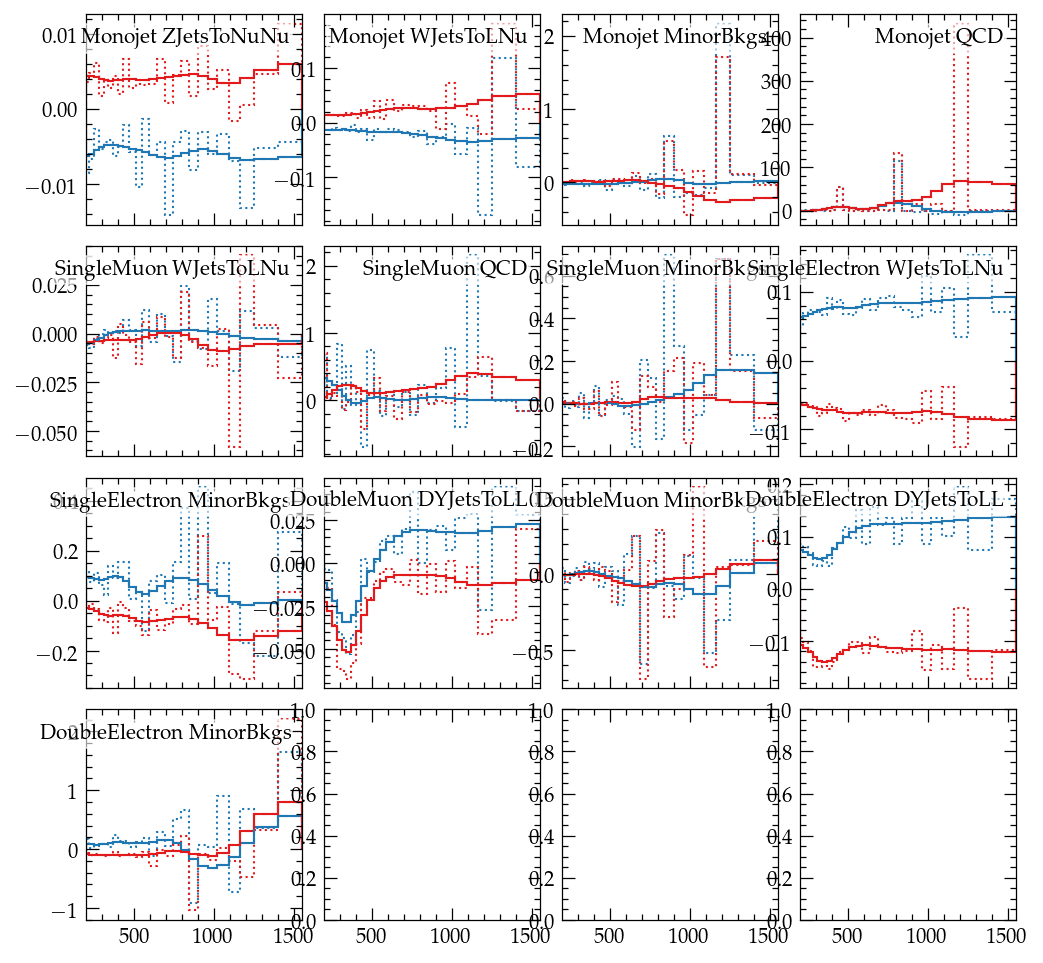

In [34]:
variation = "jerSF"

region_processes = [
    ("Monojet", "ZJetsToNuNu"),
    ("Monojet", "WJetsToLNu"),
    ("Monojet", "MinorBkgs"),
    ("Monojet", "QCD"),
    ("SingleMuon", "WJetsToLNu"),
    ("SingleMuon", "QCD"),
    ("SingleMuon", "MinorBkgs"),
    ("SingleElectron", "WJetsToLNu"),
    ("SingleElectron", "MinorBkgs"),
    ("DoubleMuon", "DYJetsToLL"),
    ("DoubleMuon", "MinorBkgs"),
    ("DoubleElectron", "DYJetsToLL"),
    ("DoubleElectron", "MinorBkgs"),
]

nvars = len(region_processes)

fig, ax = plt.subplots(
    figsize=(8, 2*((nvars//4) + 1)), dpi=150,
    nrows=(nvars//4)+1, ncols=4,
    sharex=True, sharey=False,
    gridspec_kw={"hspace":0.1, "wspace":0.1},
)

for idx, (region, process) in enumerate(region_processes):
    nom = df_mc_fit.loc[(region, process, "")]
    vari_up = df_mc_fit.loc[(region, process, "{}Up".format(variation))]
    vari_up_smooth = df_mc_fit_smooth.loc[(region, process, "{}Up".format(variation))]
    vari_up_pol = df_mc_fit_pol4.loc[(region, process, "{}Up".format(variation))]
    vari_do = df_mc_fit.loc[(region, process, "{}Down".format(variation))]
    vari_do_smooth = df_mc_fit_smooth.loc[(region, process, "{}Down".format(variation))]
    vari_do_pol = df_mc_fit_pol4.loc[(region, process, "{}Down".format(variation))]
    
    row = idx//4
    col = idx%4
    if len(region_processes)<=4:
        tax = ax[col]
    else:
        tax = ax[row,col]
    draw(
        tax,
        vari_up/nom-1, vari_up_smooth/nom-1, vari_up_pol/nom-1,
        vari_do/nom-1, vari_do_smooth/nom-1, vari_do_pol/nom-1,
        title=" ".join([region, process]),
    )

(array([-0.00749464, -0.00701264, -0.0062083 , -0.00533115, -0.00460178,
        -0.00411911, -0.00385758, -0.00372569, -0.0036252 , -0.00351402,
        -0.00346804, -0.00365473, -0.00418169, -0.00497376, -0.00584288,
        -0.00665008, -0.00729631, -0.00753524, -0.00694301, -0.0052391 ,
        -0.00264425,  0.00014993,  0.00239558,  0.00372945,  0.00426705]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 1 Patch objects>)

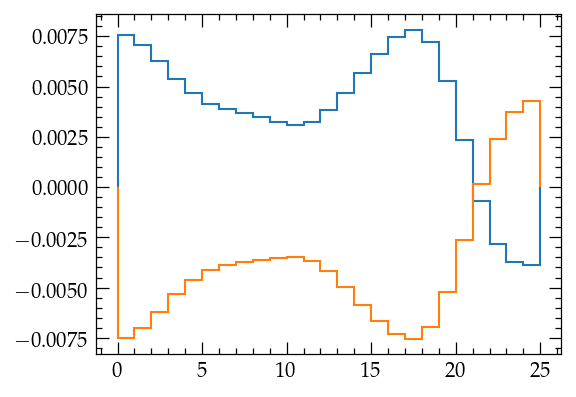

In [30]:
fig, ax = plt.subplots(
    figsize=(4, 3), dpi=150,
)

up = df_mc_fit_smooth.loc[("SingleMuon", "WJetsToLNu", "pileupUp"),"sum_w"]/df_mc_fit_smooth.loc[("SingleMuon", "WJetsToLNu", ""),"sum_w"] - 1.
down = df_mc_fit_smooth.loc[("SingleMuon", "WJetsToLNu", "pileupDown"),"sum_w"]/df_mc_fit_smooth.loc[("SingleMuon", "WJetsToLNu", ""),"sum_w"] - 1.

ax.hist(
    np.arange(0, up.shape[0], 1),
    bins=np.arange(0, up.shape[0]+1, 1),
    weights=up, histtype='step',
)
ax.hist(
    np.arange(0, up.shape[0], 1),
    bins=np.arange(0, up.shape[0]+1, 1),
    weights=down, histtype='step',
)